In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <아보카도 가격 예측>

본 과제의 목표는 아보카도 가격의 변화를 관찰하고 시계열 분석을 통해 예측하고자 함에 있다.

분석의 순서는 다음과 같다.
* Step 1. 데이터 가져오기
* Step 2. 데이터 전처리
* Step 3. 데이터 시각화
* Step 4. 시계열 분석
* Step 5. 모델 평가


# Step 1. 데이터 가져오기

In [ ]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd 
import datetime as dt

# 시각화 라이브러리
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 시계열 분석 라이브러리
from fbprophet import Prophet

# 파이프라인 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
# 데이터 불러오기
DATA_PATH = "../input/avocado-prices/avocado.csv"

def load_data():
    return pd.read_csv(DATA_PATH)

avocado = load_data()

# Step 2. 데이터 전처리

본 과제에서 이용된 데이터는 Hass Avocado Board website에서 2018년 5월에 공개한 Avocado Prices로, 미국 소매 상점에서 판매된 아보카도의 주간 수량과 가격을 포함하고 있다 (https://www.kaggle.com/neuromusic/avocado-prices).
각각의 열은 다음과 같은 데이터를 포함하고 있다.

* Date: 판매된 날짜 
* AveragePrice: 아보카도 한개의 평균 가격
* Total Volume: 판매된 아보카도의 전체 수량
* 4046: 판매된 PLU 4046 아보카도의 갯수 (작은 Hass 아보카도)
* 4225: 판매된 PLU 4225 아보카도의 갯수 (큰 Hass 아보카도)
* 4770: 판매된 PLU 4770 아보카도의 갯수 (매우 큰 Hass 아보카도)
* type: 일반(conventional) 또는 유기농(organic)
* year: 년도
* Region: 판매된 도시

Total Bags, Small Bags, Large Bags, XLarge Bags는 Bag으로 포장되어 팔린 갯수와 관련한 데이터로, 아보카도의 가격과는 연관성이 없다고 판단되어 본 과제의 분석에서 제외한다.

In [ ]:
avocado.head()

In [ ]:
# 불필요한 열 삭제
avocado = avocado.drop(['Unnamed: 0', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'], 1)
# 열 이름 재설정
names = ["date", "average_price", "total_volume", "small", "large", "xlarge", "type", "year", "region"]
avocado = avocado.rename(columns=dict(zip(avocado.columns, names)))

avocado.head()

In [ ]:
# 데이터 형식 살펴보기
avocado.info()

In [ ]:
# float 타입 데이터 살펴보기 
avocado.describe()

In [ ]:
# object 타입 데이터 살펴보기
avocado["type"].value_counts()

In [ ]:
avocado["region"].value_counts()

In [ ]:
# date 열의 데이터가 datatime 타입이 아니기 때문에, 날짜를 년, 월, 일로 나누기
dates = [dt.datetime.strptime(ts, "%Y-%m-%d") for ts in avocado['date']]
dates.sort()
sorted_dates = [dt.datetime.strftime(ts, "%Y-%m-%d") for ts in dates]
avocado['date'] = pd.DataFrame({'date':sorted_dates})
avocado['year'], avocado['month'], avocado['day'] = avocado['date'].str.split('-').str
avocado.head()

# Step 3. 데이터 시각화

In [ ]:
# 모든 float 타입 데이터 시각화하여 살펴보기
avocado.hist(bins=50, figsize=(10, 10))
plt.show()

In [ ]:
# 평균 가격 데이터만 시각화하여 살펴보기
plt.figure(figsize=(15,5))
ax = sns.distplot(avocado["average_price"])

아보카도의 평균 가격이 대체적으로 1~1.5달러임을 알 수 있다.

In [ ]:
# 특성 사이의 상관관계 확인
from pandas.plotting import scatter_matrix
attributes = ["average_price", "total_volume", "small", "large", "xlarge"]
scatter_matrix(avocado[attributes], figsize=(12, 8))

평균 가격이 1달러 언저리일 때, 모든 크기의 아보카도가 많이 팔리는 경향에 있다.

total volume, small, large, xlarge는 수량과 관련된 특성으로 1차 함수의 관계를 갖는다.

In [ ]:
# 날짜에 따른 가격 분포 살펴보기
price_date=avocado.groupby('date').mean()
plt.figure(figsize=(15,5))
price_date['average_price'].plot(x=avocado.date)
plt.title('Average Price')

아보카도 가격은 전체적으로 꾸준히 상승하는 경향을 보이나, 한달을 기준으로 증가했다 감소하는 반복적 추세를 보인다

In [ ]:
# 년도에 따른 가격 분포 살펴보기
price_year=avocado.groupby('year').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_year['average_price'].plot(x=avocado. year)
plt.title('Average Price by Year')

연도에 따른 아보카도 가격의 변화를 통해 2015년부터 아보카도 가격은 꾸준히 상승했으며 그 상승폭은 작아지고 있음을 알 수 있다.

In [ ]:
# 월별 가격 분포 살펴보기
price_month=avocado.groupby('month').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_month['average_price'].plot(x=avocado.month)
plt.title('Average Price by Month')

월별 아보카도 가격의 변화를 통해 7월부터 아보카도 가격이 상승하다가 1월이 되면 하락하는 추세를 확인할 수 있다.

In [ ]:
# 일별 가격 분포 살펴보기
price_day=avocado.groupby('day').mean()
fig, ax = plt.subplots(figsize=(15,5))
price_day['average_price'].plot(x=avocado.day)
plt.title('Average Price by Day')

일별 아보카도 가격의 변화를 통해 한달 중 6일에 아보카도 가격이 최저이며, 9일에 최대인 것을 확인할 수 있다.

In [ ]:
# 지방에 따른 연도별 아보카도 평균 가격 살펴보기
plt.figure(figsize=(30,15))
sns.pointplot(x='average_price', y='region', data=avocado, hue='year',join=False)
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title("Average Price by Year in Each Region")

지방에 따라 년도별 아보카도의 평균 가격이 상이하나, 모두 꾸준히 증가하는 추세를 보인다

모든 지방이 2015년에 아보카도가 가장 저렴했지만, 최고 가격인 연도는 지방에 따라 다르다. 하지만 본 과제에 사용된 데이터가 2018년 초기까지만 관찰된 데이터이기 때문에 발생한 오류일 수 있다.

# Step 4. 시계열 분석

In [ ]:
# 시계열 분석을 위한 데이터 프레임 만들기
df_avocado = avocado.loc[:, ["date","average_price"]]
df_avocado['date'] = pd.DatetimeIndex(df_avocado['date'])

# 시계열 분석을 위한 열 이름 바꾸기
df_avocado = df_avocado.rename(columns={'date': 'ds', 'average_price': 'y'})
df_avocado.head()

In [ ]:
df_avocado.dtypes

In [ ]:
# 훈련 데이터와 테스트 데이터 나누기
n_data = 1296
train_avocado = df_avocado[:-n_data]
test_avocado = df_avocado[-n_data:]
print(len(train_avocado), "train +", len(test_avocado), "test")

In [ ]:
test_avocado.head()

In [ ]:
# 계절성 고려
train_avocado['cap'] = train_avocado.y.max()
train_avocado['floor'] = train_avocado.y.min()

time_model = Prophet(growth='logistic', interval_width=0.95)
time_model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
time_model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
time_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

time_model.fit(train_avocado)

In [ ]:
# 미래 가격 예측
future_dates = time_model.make_future_dataframe(periods=12, freq='w')
future_dates['cap'] = train_avocado.y.max()
future_dates['floor'] = train_avocado.y.min()

forecast = time_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# ds: the datestamp of the forecasted value
# yhat: the forecasted value of metric
# yhat_lower: the lower bound of forecasts
# yhat_upper: the upper bound of forecasts

In [ ]:
fig = time_model.plot(forecast)

In [ ]:
fig = time_model.plot_components(forecast)

In [ ]:
# 예측된 그래프 살펴보기
forecast_copy = forecast['ds']
forecast_copy2 = forecast['yhat']
forecast_copy = pd.concat([forecast_copy,forecast_copy2], axis=1)

mask = (forecast_copy['ds'] > "2018-01-07") & (forecast_copy['ds'] <= "2018-03-25")
forecasted_values = forecast_copy.loc[mask]
mask = (forecast_copy['ds'] > "2015-01-04") & (forecast_copy['ds'] <= "2018-01-07")
forecast_copy = forecast_copy.loc[mask]

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(forecast_copy.set_index('ds'), color='b')
ax1.plot(forecasted_values.set_index('ds'), color='r')
ax1.set_ylabel('Average Prices')
ax1.set_xlabel('Date')
print("Red = Predicted Values, Blue = Base Values")

# Step 5. 모델 평가

In [ ]:
# 평가를 위해 테스트 테이터 가져오기
test_avocado = pd.concat([test_avocado.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

columns = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test_avocado = test_avocado[columns]

test_avocado.head()

Measuring forecast accuracy (https://pdfs.semanticscholar.org/af71/3d815a7caba8dff7248ecea05a5956b2a487.pdf)
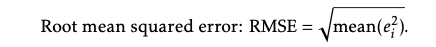


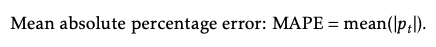 

In [ ]:
# 정확성 측정
test_avocado['e'] = test_avocado.y - test_avocado.yhat
rmse = np.sqrt(np.mean(test_avocado.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test_avocado.e/test_avocado.y)), 0)
print('RMSE = $', rmse)
print('MAPE =', mape, '%')

에러값의 평균은 0.4달러이며 퍼센티지로는 20%이다.